<a href="https://colab.research.google.com/github/quothbonney/scripts/blob/master/TUDELAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import division
import torch
import math
import sys
import random
from PIL import Image
try:
    import accimage
except ImportError:
    accimage = None
import numpy as np
import numbers
import types
import collections
import warnings

from torchvision.transforms import functional as F

if sys.version_info < (3, 3):
    Sequence = collections.Sequence
    Iterable = collections.Iterable
else:
    Sequence = collections.abc.Sequence
    Iterable = collections.abc.Iterable

__all__ = ["Compose", "ToTensor", "ToPILImage", "Normalize", "Resize", "Scale", "CenterCrop", "Pad",
           "Lambda", "RandomApply", "RandomChoice", "RandomOrder", "RandomCrop", "RandomHorizontalFlip",
           "RandomVerticalFlip", "RandomResizedCrop", "RandomSizedCrop", "FiveCrop", "TenCrop", "LinearTransformation",
           "ColorJitter", "RandomRotation", "RandomAffine", "Grayscale", "RandomGrayscale",
           "RandomPerspective", "RandomErasing"]

_pil_interpolation_to_str = {
    Image.NEAREST: 'PIL.Image.NEAREST',
    Image.BILINEAR: 'PIL.Image.BILINEAR',
    Image.BICUBIC: 'PIL.Image.BICUBIC',
    Image.LANCZOS: 'PIL.Image.LANCZOS',
    Image.HAMMING: 'PIL.Image.HAMMING',
    Image.BOX: 'PIL.Image.BOX',
}

def _get_image_size(img):
    if F._is_pil_image(img):
        return img.size
    elif isinstance(img, torch.Tensor) and img.dim() > 2:
        return img.shape[-2:][::-1]
    else:
        raise TypeError("Unexpected type {}".format(type(img)))

class Compose(object):
    """Composes several transforms together. Generalized to apply each transform
    to two images if they are supplied

    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.

    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, target = None):
        if target is not None:
            for t in self.transforms:
                img, target = t(img, target)
            return img, target

        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string


class ToTensor(object):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor. Generalized to convert to
    tensors two images if they are supplied.

    Converts a PIL Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
    or if the numpy.ndarray has dtype = np.uint8

    In the other cases, tensors are returned without scaling.

    If a target image (of shape HxW) is provided, this will also return a tensorized version of it.
    Note that no scaling will take place, and the target tensor will be returned with type long.
    Note that the output shape will not be 1xHxW but rather HxW.
    """

    def __call__(self, pic, pic2=None):
        """
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
            pic2 (PIL Image): (optional) Second image to be converted also.

        Returns:
            Tensor(s): Converted image(s).
        """
        if pic2 is not None:
            return F.to_tensor(pic), F.to_tensor(pic2).mul(255).long()[0]
        return F.to_tensor(pic)

    def __repr__(self):
        return self.__class__.__name__ + '()'


class ToPILImage(object):
    """Convert a tensor or an ndarray to PIL Image. Generalized to convert to
    tensors two images if they are supplied.

    Converts a torch.*Tensor of shape C x H x W or a numpy ndarray of shape
    H x W x C to a PIL Image while preserving the value range.

    Args:
        mode (`PIL.Image mode`_): color space and pixel depth of input data (optional).
            If ``mode`` is ``None`` (default) there are some assumptions made about the input data:
             - If the input has 4 channels, the ``mode`` is assumed to be ``RGBA``.
             - If the input has 3 channels, the ``mode`` is assumed to be ``RGB``.
             - If the input has 2 channels, the ``mode`` is assumed to be ``LA``.
             - If the input has 1 channel, the ``mode`` is determined by the data type (i.e ``int``, ``float``,
               ``short``).

    .. _PIL.Image mode: https://pillow.readthedocs.io/en/latest/handbook/concepts.html#concept-modes
    """
    def __init__(self, mode=None):
        self.mode = mode

    def __call__(self, pic, pic2=None):
        """
        Args:
            pic (Tensor or numpy.ndarray): Image to be converted to PIL Image.
            pic2 (Tensor or numpy.ndarray): (optional) Second image to be converted also.

        Returns:
            PIL Image(s): Image(s) converted to PIL Image(s).

        """
        if pic2 is not None:
            return F.to_pil_image(pic), F.to_pil_image(np.uint8(pic2.numpy()))
        return F.to_pil_image(pic, self.mode)

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        if self.mode is not None:
            format_string += 'mode={0}'.format(self.mode)
        format_string += ')'
        return format_string


class Normalize(object):
    """Normalize a tensor image with mean and standard deviation.
    Given mean: ``(M1,...,Mn)`` and std: ``(S1,..,Sn)`` for ``n`` channels, this transform
    will normalize each channel of the input ``torch.*Tensor`` i.e.
    ``input[channel] = (input[channel] - mean[channel]) / std[channel]``

    .. note::
        This transform acts out of place, i.e., it does not mutates the input tensor.

    .. note::
        If the input are two tensors, this transform only normalizes the first one

    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
        inplace(bool,optional): Bool to make this operation in-place.

    """

    def __init__(self, mean, std, inplace=False):
        self.mean = mean
        self.std = std
        self.inplace = inplace

    def __call__(self, tensor, tensor2=None):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
            optionally a second tensor that will be return without modifications

        Returns:
            Tensor: Normalized Tensor image. Optionally second input tensor
        """
        if tensor2 is not None:
            return F.normalize(tensor, self.mean, self.std), tensor2
        return F.normalize(tensor, self.mean, self.std)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


class Resize(object):
    """Resize the input PIL Image to the given size.

    Args:
        size (sequence or int): Desired output size. If size is a sequence like
            (h, w), output size will be matched to this. If size is an int,
            smaller edge of the image will be matched to this number.
            i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
        interpolation_tg (int, optional): Desired interpolation for target. Default is
            ``PIL.Image.NEAREST``
    """

    def __init__(self, size, interpolation=Image.BILINEAR, interpolation_tg = Image.NEAREST):
        assert isinstance(size, int) or (isinstance(size, Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation
        self.interpolation_tg = interpolation_tg

    def __call__(self, img, target=None):
        """
        Args:
            img (PIL Image): Image to be scaled.
            target (PIL Image): (optional) Target to be scaled

        Returns:
            PIL Image: Rescaled image(s).
        """
        if target is not None:
            return F.resize(img, self.size, self.interpolation), \
                   F.resize(target, self.size, self.interpolation_tg)
        return F.resize(img, self.size, self.interpolation)

    def __repr__(self):
        interpolate_str = _pil_interpolation_to_str[self.interpolation]
        return self.__class__.__name__ + '(size={0}, interpolation={1})'.format(self.size, interpolate_str)


class Scale(Resize):
    """
    Note: This transform is deprecated in favor of Resize.
    """
    def __init__(self, *args, **kwargs):
        warnings.warn("The use of the transforms.Scale transform is deprecated, " +
                      "please use transforms.Resize instead.")
        super(Scale, self).__init__(*args, **kwargs)


class CenterCrop(object):
    """Crops the given PIL Image at the center.

    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
    """

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img, target=None):
        """
        Args:
            img (PIL Image): Image to be cropped.
            target (PIL Image): (optional) Target to be cropped

        Returns:
            PIL Image: Cropped image(s).
        """
        if target is not None:
            return F.center_crop(img, self.size), F.center_crop(target, self.size)
        return F.center_crop(img, self.size)

    def __repr__(self):
        return self.__class__.__name__ + '(size={0})'.format(self.size)


class Pad(object):
    """Pad the given PIL Image on all sides with the given "pad" value. Generalized to convert to
    tensors two images if they are supplied. Handle with care the way you pad the segm. mask!

    Args:
        padding (int or tuple): Padding on each border. If a single int is provided this
            is used to pad all borders. If tuple of length 2 is provided this is the padding
            on left/right and top/bottom respectively. If a tuple of length 4 is provided
            this is the padding for the left, top, right and bottom borders
            respectively.
        fill (int or tuple): Pixel fill value for constant fill. Default is 0. If a tuple of
            length 3, it is used to fill R, G, B channels respectively.
            This value is only used when the padding_mode is constant
        padding_mode (str): Type of padding. Should be: constant, edge, reflect or symmetric.
            Default is constant.

            - constant: pads with a constant value, this value is specified with fill

            - edge: pads with the last value at the edge of the image

            - reflect: pads with reflection of image without repeating the last value on the edge

                For example, padding [1, 2, 3, 4] with 2 elements on both sides in reflect mode
                will result in [3, 2, 1, 2, 3, 4, 3, 2]

            - symmetric: pads with reflection of image repeating the last value on the edge

                For example, padding [1, 2, 3, 4] with 2 elements on both sides in symmetric mode
                will result in [2, 1, 1, 2, 3, 4, 4, 3]
    """

    def __init__(self, padding, fill=0, padding_mode='constant'):
        assert isinstance(padding, (numbers.Number, tuple))
        assert isinstance(fill, (numbers.Number, str, tuple))
        assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric']
        if isinstance(padding, Sequence) and len(padding) not in [2, 4]:
            raise ValueError("Padding must be an int or a 2, or 4 element tuple, not a " +
                             "{} element tuple".format(len(padding)))

        self.padding = padding
        self.fill = fill
        self.padding_mode = padding_mode

    def __call__(self, img, target=None):
        """
        Args:
            img (PIL Image): Image to be padded.
            target (PIL Image): (optional) Target to be padded

        Returns:
            PIL Image(s): Padded image(s).
        """
        if target is not None:
            return F.pad(img, self.padding, self.fill, self.padding_mode), \
                   F.pad(target, self.padding, self.fill, self.padding_mode)
        return F.pad(img, self.padding, self.fill, self.padding_mode)

    def __repr__(self):
        return self.__class__.__name__ + '(padding={0}, fill={1}, padding_mode={2})'.\
            format(self.padding, self.fill, self.padding_mode)


class Lambda(object):
    """Apply a user-defined lambda as a transform.

    Args:
        lambd (function): Lambda/function to be used for transform.
    """

    def __init__(self, lambd):
        assert callable(lambd), repr(type(lambd).__name__) + " object is not callable"
        self.lambd = lambd

    def __call__(self, img, target=None):
        if target is not None:
            return self.lambd(img), target
        return self.lambd(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'


class RandomTransforms(object):
    """Base class for a list of transformations with randomness

    Args:
        transforms (list or tuple): list of transformations
    """

    def __init__(self, transforms):
        assert isinstance(transforms, (list, tuple))
        self.transforms = transforms

    def __call__(self, *args, **kwargs):
        raise NotImplementedError()

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string


class RandomApply(RandomTransforms):
    """Apply randomly a list of transformations with a given probability

    Args:
        transforms (list or tuple): list of transformations
        p (float): probability
    """

    def __init__(self, transforms, p=0.5):
        super(RandomApply, self).__init__(transforms)
        self.p = p

    def __call__(self, img, target=None):
        if self.p < random.random():
            if target is not None:
                return img, target
            return img
        for t in self.transforms:
            if target is not None:
                img, target = t(img, target)
            else:
                img = t(img)
        if target is not None:
            return img, target
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        format_string += '\n    p={}'.format(self.p)
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string


class RandomOrder(RandomTransforms):
    """Apply a list of transformations in a random order
    """
    def __call__(self, img, target=None):
        order = list(range(len(self.transforms)))
        random.shuffle(order)
        for i in order:
            if target is not None:
                img, target = self.transforms[i](img, target)
            else:
                img = self.transforms[i](img)
        if target is not None:
            return img, target
        return img


class RandomChoice(RandomTransforms):
    """Apply single transformation randomly picked from a list
    """
    def __call__(self, img, target=None):
        t = random.choice(self.transforms)
        if target is not None:
            return t(img, target)
        return t(img)


class RandomCrop(object):
    """Crop the given PIL Image at a random location.

    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is None, i.e no padding. If a sequence of length
            4 is provided, it is used to pad left, top, right, bottom borders
            respectively. If a sequence of length 2 is provided, it is used to
            pad left/right, top/bottom borders, respectively.
        pad_if_needed (boolean): It will pad the image if smaller than the
            desired size to avoid raising an exception. Since cropping is done
            after padding, the padding seems to be done at a random offset.
        fill: Pixel fill value for constant fill. Default is 0. If a tuple of
            length 3, it is used to fill R, G, B channels respectively.
            This value is only used when the padding_mode is constant
        padding_mode: Type of padding. Should be: constant, edge, reflect or symmetric. Default is constant.

             - constant: pads with a constant value, this value is specified with fill

             - edge: pads with the last value on the edge of the image

             - reflect: pads with reflection of image (without repeating the last value on the edge)

                padding [1, 2, 3, 4] with 2 elements on both sides in reflect mode
                will result in [3, 2, 1, 2, 3, 4, 3, 2]

             - symmetric: pads with reflection of image (repeating the last value on the edge)

                padding [1, 2, 3, 4] with 2 elements on both sides in symmetric mode
                will result in [2, 1, 1, 2, 3, 4, 4, 3]

    """

    def __init__(self, size, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        self.pad_if_needed = pad_if_needed
        self.fill = fill
        self.padding_mode = padding_mode

    @staticmethod
    def get_params(img, output_size):
        """Get parameters for ``crop`` for a random crop.

        Args:
            img (PIL Image): Image to be cropped.
            output_size (tuple): Expected output size of the crop.

        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
        """
        w, h = img.size
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, img, target = None):
        """
        Args:
            img (PIL Image): Image to be cropped.
            target (PIL Image): (optional) Target to be cropped

        Returns:
            PIL Images: Cropped image(s).
        """
        if self.padding is not None:
            img = F.pad(img, self.padding, self.fill, self.padding_mode)
            if target is not None:
                target = F.pad(target, self.padding, self.fill, self.padding_mode)

        # pad the width if needed
        if self.pad_if_needed and img.size[0] < self.size[1]:
            img = F.pad(img, (self.size[1] - img.size[0], 0), self.fill, self.padding_mode)
            if target is not None:
                target = F.pad(target, (self.size[1] - target.size[0], 0), self.fill, self.padding_mode)
        # pad the height if needed
        if self.pad_if_needed and img.size[1] < self.size[0]:
            img = F.pad(img, (0, self.size[0] - img.size[1]), self.fill, self.padding_mode)
            if target is not None:
                target = F.pad(target , (0, self.size[0] - target .size[1]), self.fill, self.padding_mode)
        i, j, h, w = self.get_params(img, self.size)

        if target is not None:
            return F.crop(img, i, j, h, w), F.crop(target, i, j, h, w)
        return F.crop(img, i, j, h, w)

    def __repr__(self):
        return self.__class__.__name__ + '(size={0}, padding={1})'.format(self.size, self.padding)


class RandomHorizontalFlip(object):
    """Horizontally flip the given PIL Image randomly with a given probability.

    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, target=None):
        """
        Args:
            img (PIL Image): Image to be flipped.
            target (PIL Image): (optional) Target to be flipped

        Returns:
            PIL Image: Randomly flipped image(s).
        """
        if random.random() < self.p:
            if target is not None:
                return F.hflip(img), F.hflip(target)
            else:
                return F.hflip(img)

        if target is not None:
            return img, target
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)


class RandomVerticalFlip(object):
    """Vertically flip the given PIL Image randomly with a given probability.

    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, target=None):
        """
        Args:
            img (PIL Image): Image to be flipped.
            target (PIL Image): (optional) Target to be flipped

        Returns:
            PIL Image: Randomly flipped image(s).
        """
        if random.random() < self.p:
            if target is not None:
                return F.vflip(img), F.vflip(target)
            else:
                return F.vflip(img)

        if target is not None:
            return img, target
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)


class RandomPerspective(object):
    """Performs Perspective transformation of the given PIL Image randomly with a given probability.

    Args:
        interpolation : Default- Image.BICUBIC

        interpolation_tg : Default- Image.NEAREST

        p (float): probability of the image being perspectively transformed. Default value is 0.5

        distortion_scale(float): it controls the degree of distortion and ranges from 0 to 1. Default value is 0.5.

    """

    def __init__(self, distortion_scale=0.5, p=0.5,
                 interpolation=Image.BICUBIC, interpolation_tg = Image.NEAREST):
        self.p = p
        self.interpolation = interpolation
        self.interpolation_tg = interpolation_tg
        self.distortion_scale = distortion_scale

    def __call__(self, img, target = None):
        """
        Args:
            img (PIL Image): Image to be Perspectively transformed.
            target (PIL Image): (optional) Target to be Perspectively transformed.

        Returns:
            PIL Image(s): Random perspectivley transformed image(s).
        """
        if not F._is_pil_image(img):
            raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

        if random.random() < self.p:
            width, height = img.size
            startpoints, endpoints = self.get_params(width, height, self.distortion_scale)
            if target is not None:
                return F.perspective(img, startpoints, endpoints, self.interpolation), \
                       F.perspective(target, startpoints, endpoints, self.interpolation_tg)
            return F.perspective(img, startpoints, endpoints, self.interpolation)
        if target is not None:
            return img, target
        return img

    @staticmethod
    def get_params(width, height, distortion_scale):
        """Get parameters for ``perspective`` for a random perspective transform.

        Args:
            width : width of the image.
            height : height of the image.

        Returns:
            List containing [top-left, top-right, bottom-right, bottom-left] of the original image,
            List containing [top-left, top-right, bottom-right, bottom-left] of the transformed image.
        """
        half_height = int(height / 2)
        half_width = int(width / 2)
        topleft = (random.randint(0, int(distortion_scale * half_width)),
                   random.randint(0, int(distortion_scale * half_height)))
        topright = (random.randint(width - int(distortion_scale * half_width) - 1, width - 1),
                    random.randint(0, int(distortion_scale * half_height)))
        botright = (random.randint(width - int(distortion_scale * half_width) - 1, width - 1),
                    random.randint(height - int(distortion_scale * half_height) - 1, height - 1))
        botleft = (random.randint(0, int(distortion_scale * half_width)),
                   random.randint(height - int(distortion_scale * half_height) - 1, height - 1))
        startpoints = [(0, 0), (width - 1, 0), (width - 1, height - 1), (0, height - 1)]
        endpoints = [topleft, topright, botright, botleft]
        return startpoints, endpoints

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)


class RandomResizedCrop(object):
    """Crop the given PIL Image to random size and aspect ratio.

    A crop of random size (default: of 0.08 to 1.0) of the original size and a random
    aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. This crop
    is finally resized to given size.
    This is popularly used to train the Inception networks.

    Args:
        size: expected output size of each edge
        scale: range of size of the origin size cropped
        ratio: range of aspect ratio of the origin aspect ratio cropped
        interpolation: Default: PIL.Image.BILINEAR
        interpolation_tg : Default- Image.NEAREST
    """

    def __init__(self, size, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.),
                 interpolation=Image.BILINEAR, interpolation_tg = Image.NEAREST):
        if isinstance(size, tuple):
            self.size = size
        else:
            self.size = (size, size)
        if (scale[0] > scale[1]) or (ratio[0] > ratio[1]):
            warnings.warn("range should be of kind (min, max)")

        self.interpolation = interpolation
        self.interpolation_tg = interpolation_tg
        self.scale = scale
        self.ratio = ratio

    @staticmethod
    def get_params(img, scale, ratio):
        """Get parameters for ``crop`` for a random sized crop.

        Args:
            img (PIL Image): Image to be cropped.
            scale (tuple): range of size of the origin size cropped
            ratio (tuple): range of aspect ratio of the origin aspect ratio cropped

        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for a random
                sized crop.
        """
        width, height = _get_image_size(img)
        area = height * width

        for attempt in range(10):
            target_area = random.uniform(*scale) * area
            log_ratio = (math.log(ratio[0]), math.log(ratio[1]))
            aspect_ratio = math.exp(random.uniform(*log_ratio))

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if 0 < w <= width and 0 < h <= height:
                i = random.randint(0, height - h)
                j = random.randint(0, width - w)
                return i, j, h, w

        # Fallback to central crop
        in_ratio = float(width) / float(height)
        if (in_ratio < min(ratio)):
            w = width
            h = int(round(w / min(ratio)))
        elif (in_ratio > max(ratio)):
            h = height
            w = int(round(h * max(ratio)))
        else:  # whole image
            w = width
            h = height
        i = (height - h) // 2
        j = (width - w) // 2
        return i, j, h, w

    def __call__(self, img, target = None):
        """
        Args:
            img (PIL Image): Image to be cropped and resized.
            target (PIL Image): (optional) Target to be cropped and resized.

        Returns:
            PIL Image: Randomly cropped and resized image(s).
        """
        i, j, h, w = self.get_params(img, self.scale, self.ratio)
        if target is not None:
            return F.resized_crop(img, i, j, h, w, self.size, self.interpolation), \
                   F.resized_crop(target, i, j, h, w, self.size, self.interpolation_tg)
        return F.resized_crop(img, i, j, h, w, self.size, self.interpolation)

    def __repr__(self):
        interpolate_str = _pil_interpolation_to_str[self.interpolation]
        format_string = self.__class__.__name__ + '(size={0}'.format(self.size)
        format_string += ', scale={0}'.format(tuple(round(s, 4) for s in self.scale))
        format_string += ', ratio={0}'.format(tuple(round(r, 4) for r in self.ratio))
        format_string += ', interpolation={0})'.format(interpolate_str)
        return format_string


class RandomSizedCrop(RandomResizedCrop):
    """
    Note: This transform is deprecated in favor of RandomResizedCrop.
    """
    def __init__(self, *args, **kwargs):
        warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +
                      "please use transforms.RandomResizedCrop instead.")
        super(RandomSizedCrop, self).__init__(*args, **kwargs)


class FiveCrop(object):
    """Crop the given PIL Image into four corners and the central crop

    .. Note::
         This transform returns a tuple of images and there may be a mismatch in the number of
         inputs and targets your Dataset returns. See below for an example of how to deal with
         this.

    Args:
         size (sequence or int): Desired output size of the crop. If size is an ``int``
            instead of sequence like (h, w), a square crop of size (size, size) is made.

    Example:
         >>> transform = Compose([
         >>>    FiveCrop(size), # this is a list of PIL Images
         >>>    Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops])) # returns a 4D tensor
         >>> ])
         >>> #In your test loop you can do the following:
         >>> input, target = batch # input is a 5d tensor, target is 2d
         >>> bs, ncrops, c, h, w = input.size()
         >>> result = model(input.view(-1, c, h, w)) # fuse batch size and ncrops
         >>> result_avg = result.view(bs, ncrops, -1).mean(1) # avg over crops
    """

    def __init__(self, size):
        self.size = size
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            assert len(size) == 2, "Please provide only two dimensions (h, w) for size."
            self.size = size

    def __call__(self, img, target=None):
        if target is not None:
            return F.five_crop(img, self.size), F.five_crop(target, self.size)
        return F.five_crop(img, self.size)

    def __repr__(self):
        return self.__class__.__name__ + '(size={0})'.format(self.size)


class TenCrop(object):
    """Crop the given PIL Image into four corners and the central crop plus the flipped version of
    these (horizontal flipping is used by default)

    .. Note::
         This transform returns a tuple of images and there may be a mismatch in the number of
         inputs and targets your Dataset returns. See below for an example of how to deal with
         this.

    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        vertical_flip(bool): Use vertical flipping instead of horizontal

    Example:
         >>> transform = Compose([
         >>>    TenCrop(size), # this is a list of PIL Images
         >>>    Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops])) # returns a 4D tensor
         >>> ])
         >>> #In your test loop you can do the following:
         >>> input, target = batch # input is a 5d tensor, target is 2d
         >>> bs, ncrops, c, h, w = input.size()
         >>> result = model(input.view(-1, c, h, w)) # fuse batch size and ncrops
         >>> result_avg = result.view(bs, ncrops, -1).mean(1) # avg over crops
    """

    def __init__(self, size, vertical_flip=False):
        self.size = size
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            assert len(size) == 2, "Please provide only two dimensions (h, w) for size."
            self.size = size
        self.vertical_flip = vertical_flip

    def __call__(self, img, target = None):
        if target is not None:
            return F.ten_crop(img, self.size), F.ten_crop(target, self.size)
        return F.ten_crop(img, self.size, self.vertical_flip)

    def __repr__(self):
        return self.__class__.__name__ + '(size={0}, vertical_flip={1})'.format(self.size, self.vertical_flip)


class LinearTransformation(object):
    """Transform a tensor image with a square transformation matrix computed
    offline.

    Given transformation_matrix, will flatten the torch.*Tensor, compute the dot
    product with the transformation matrix and reshape the tensor to its
    original shape.

    Applications:
    - whitening: zero-center the data, compute the data covariance matrix
                 [D x D] with np.dot(X.T, X), perform SVD on this matrix and
                 pass it as transformation_matrix.

    Args:
        transformation_matrix (Tensor): tensor [D x D], D = C x H x W
    """

    def __init__(self, transformation_matrix, mean_vector):
        if transformation_matrix.size(0) != transformation_matrix.size(1):
            raise ValueError("transformation_matrix should be square. Got " +
                             "[{} x {}] rectangular matrix.".format(*transformation_matrix.size()))

        if mean_vector.size(0) != transformation_matrix.size(0):
            raise ValueError("mean_vector should have the same length {}".format(mean_vector.size(0)) +
                             " as any one of the dimensions of the transformation_matrix [{} x {}]"
                             .format(transformation_matrix.size()))

        self.transformation_matrix = transformation_matrix
        self.mean_vector = mean_vector

    def __call__(self, tensor, target_tensor=None):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be whitened.

        Returns:
            Tensor(s): Transformed image(s).
        """
        if tensor.size(0) * tensor.size(1) * tensor.size(2) != self.transformation_matrix.size(0):
            raise ValueError("tensor and transformation matrix have incompatible shape." +
                             "[{} x {} x {}] != ".format(*tensor.size()) +
                             "{}".format(self.transformation_matrix.size(0)))
        flat_tensor = tensor.view(1, -1) - self.mean_vector
        transformed_tensor = torch.mm(flat_tensor, self.transformation_matrix)
        tensor = transformed_tensor.view(tensor.size())
        if target_tensor is not None:
            return tensor, target_tensor
        return tensor

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        format_string += (str(self.transformation_matrix.numpy().tolist()) + ')')
        return format_string


class ColorJitter(object):
    """Randomly change the brightness, contrast and saturation of an image.

    Args:
        brightness (float or tuple of float (min, max)): How much to jitter brightness.
            brightness_factor is chosen uniformly from [max(0, 1 - brightness), 1 + brightness]
            or the given [min, max]. Should be non negative numbers.
        contrast (float or tuple of float (min, max)): How much to jitter contrast.
            contrast_factor is chosen uniformly from [max(0, 1 - contrast), 1 + contrast]
            or the given [min, max]. Should be non negative numbers.
        saturation (float or tuple of float (min, max)): How much to jitter saturation.
            saturation_factor is chosen uniformly from [max(0, 1 - saturation), 1 + saturation]
            or the given [min, max]. Should be non negative numbers.
        hue (float or tuple of float (min, max)): How much to jitter hue.
            hue_factor is chosen uniformly from [-hue, hue] or the given [min, max].
            Should have 0<= hue <= 0.5 or -0.5 <= min <= max <= 0.5.
    """
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = self._check_input(brightness, 'brightness')
        self.contrast = self._check_input(contrast, 'contrast')
        self.saturation = self._check_input(saturation, 'saturation')
        self.hue = self._check_input(hue, 'hue', center=0, bound=(-0.5, 0.5),
                                     clip_first_on_zero=False)

    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError("If {} is a single number, it must be non negative.".format(name))
            value = [center - value, center + value]
            if clip_first_on_zero:
                value[0] = max(value[0], 0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError("{} values should be between {}".format(name, bound))
        else:
            raise TypeError("{} should be a single number or a list/tuple with lenght 2.".format(name))

        # if value is 0 or (1., 1.) for brightness/contrast/saturation
        # or (0., 0.) for hue, do nothing
        if value[0] == value[1] == center:
            value = None
        return value

    @staticmethod
    def get_params(brightness, contrast, saturation, hue):
        """Get a randomized transform to be applied on image.

        Arguments are same as that of __init__.

        Returns:
            Transform which randomly adjusts brightness, contrast and
            saturation in a random order.
        """
        transforms = []

        if brightness is not None:
            brightness_factor = random.uniform(brightness[0], brightness[1])
            transforms.append(Lambda(lambda img: F.adjust_brightness(img, brightness_factor)))

        if contrast is not None:
            contrast_factor = random.uniform(contrast[0], contrast[1])
            transforms.append(Lambda(lambda img: F.adjust_contrast(img, contrast_factor)))

        if saturation is not None:
            saturation_factor = random.uniform(saturation[0], saturation[1])
            transforms.append(Lambda(lambda img: F.adjust_saturation(img, saturation_factor)))

        if hue is not None:
            hue_factor = random.uniform(hue[0], hue[1])
            transforms.append(Lambda(lambda img: F.adjust_hue(img, hue_factor)))

        random.shuffle(transforms)
        transform = Compose(transforms)

        return transform

    def __call__(self, img, target = None):
        """
        Args:
            img (PIL Image): Input image.
            (PIL Image): (optional) Second image, won't be transformed.

        Returns:
            PIL Image(s): Color jittered image (and second unmodified image).
        """
        transform = self.get_params(self.brightness, self.contrast,
                                    self.saturation, self.hue)

        if target is not None:
            return transform(img), target
        return transform(img)

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        format_string += 'brightness={0}'.format(self.brightness)
        format_string += ', contrast={0}'.format(self.contrast)
        format_string += ', saturation={0}'.format(self.saturation)
        format_string += ', hue={0})'.format(self.hue)
        return format_string


class RandomRotation(object):
    """Rotate the image by angle.

    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter. See `filters`_ for more information.
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.

    .. _filters: https://pillow.readthedocs.io/en/latest/handbook/concepts.html#filters

    """

    def __init__(self, degrees, resample=False, resample_tg=False, expand=False, center=None): #,fill=0
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.resample_tg = resample_tg
        self.expand = expand
        self.center = center
        # self.fill = fill

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.

        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img, target=None):
        """
            img (PIL Image): Image to be rotated.
            target (PIL Image): (optional) Target to be rotated

        Returns:
            PIL Image: Rotated image(s).
        """

        angle = self.get_params(self.degrees)

        if target is not None:
            return F.rotate(img, angle, self.resample, self.expand, self.center), \
                   F.rotate(target, angle, self.resample_tg, self.expand, self.center) # , self.fill
                   # resample = False is by default nearest, appropriate for targets
        return F.rotate(img, angle, self.resample, self.expand, self.center) #, self.fill

    def __repr__(self):
        format_string = self.__class__.__name__ + '(degrees={0}'.format(self.degrees)
        format_string += ', resample={0}'.format(self.resample)
        format_string += ', expand={0}'.format(self.expand)
        if self.center is not None:
            format_string += ', center={0}'.format(self.center)
        format_string += ')'
        return format_string


class RandomAffine(object):
    """Random affine transformation of the image keeping center invariant

    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees). Set to 0 to deactivate rotations.
        translate (tuple, optional): tuple of maximum absolute fraction for horizontal
            and vertical translations. For example translate=(a, b), then horizontal shift
            is randomly sampled in the range -img_width * a < dx < img_width * a and vertical shift is
            randomly sampled in the range -img_height * b < dy < img_height * b. Will not translate by default.
        scale (tuple, optional): scaling factor interval, e.g (a, b), then scale is
            randomly sampled from the range a <= scale <= b. Will keep original scale by default.
        shear (sequence or float or int, optional): Range of degrees to select from.
            If shear is a number, a shear parallel to the x axis in the range (-shear, +shear)
            will be apllied. Else if shear is a tuple or list of 2 values a shear parallel to the x axis in the
            range (shear[0], shear[1]) will be applied. Else if shear is a tuple or list of 4 values,
            a x-axis shear in (shear[0], shear[1]) and y-axis shear in (shear[2], shear[3]) will be applied.
            Will not apply shear by default
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter. See `filters`_ for more information.
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        fillcolor (tuple or int): Optional fill color (Tuple for RGB Image And int for grayscale) for the area
            outside the transform in the output image.(Pillow>=5.0.0)

    .. _filters: https://pillow.readthedocs.io/en/latest/handbook/concepts.html#filters

    """

    def __init__(self, degrees, translate=None, scale=None, shear=None,
                 resample=False, resample_tg=False, fillcolor=0):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            assert isinstance(degrees, (tuple, list)) and len(degrees) == 2, \
                "degrees should be a list or tuple and it must be of length 2."
            self.degrees = degrees

        if translate is not None:
            assert isinstance(translate, (tuple, list)) and len(translate) == 2, \
                "translate should be a list or tuple and it must be of length 2."
            for t in translate:
                if not (0.0 <= t <= 1.0):
                    raise ValueError("translation values should be between 0 and 1")
        self.translate = translate

        if scale is not None:
            assert isinstance(scale, (tuple, list)) and len(scale) == 2, \
                "scale should be a list or tuple and it must be of length 2."
            for s in scale:
                if s <= 0:
                    raise ValueError("scale values should be positive")
        self.scale = scale

        if shear is not None:
            if isinstance(shear, numbers.Number):
                if shear < 0:
                    raise ValueError("If shear is a single number, it must be positive.")
                self.shear = (-shear, shear)
            else:
                assert isinstance(shear, (tuple, list)) and \
                    (len(shear) == 2 or len(shear) == 4), \
                    "shear should be a list or tuple and it must be of length 2 or 4."
                # X-Axis shear with [min, max]
                if len(shear) == 2:
                    self.shear = [shear[0], shear[1], 0., 0.]
                elif len(shear) == 4:
                    self.shear = [s for s in shear]
        else:
            self.shear = shear

        self.resample = resample
        self.resample_tg = resample_tg
        self.fillcolor = fillcolor

    @staticmethod
    def get_params(degrees, translate, scale_ranges, shears, img_size):
        """Get parameters for affine transformation

        Returns:
            sequence: params to be passed to the affine transformation
        """
        angle = random.uniform(degrees[0], degrees[1])
        if translate is not None:
            max_dx = translate[0] * img_size[0]
            max_dy = translate[1] * img_size[1]
            translations = (np.round(random.uniform(-max_dx, max_dx)),
                            np.round(random.uniform(-max_dy, max_dy)))
        else:
            translations = (0, 0)

        if scale_ranges is not None:
            scale = random.uniform(scale_ranges[0], scale_ranges[1])
        else:
            scale = 1.0

        if shears is not None:
            if len(shears) == 2:
                shear = [random.uniform(shears[0], shears[1]), 0.]
            elif len(shears) == 4:
                shear = [random.uniform(shears[0], shears[1]),
                         random.uniform(shears[2], shears[3])]
        else:
            shear = 0.0

        return angle, translations, scale, shear

    def __call__(self, img, target=None):
        """
            img (PIL Image): Image to be rotated.
            target (PIL Image): (optional) Target to be rotated

        Returns:
            PIL Image: Rotated image(s).
        """
        ret = self.get_params(self.degrees, self.translate, self.scale, self.shear, img.size)
        if target is not None:
            return F.affine(img, *ret, resample=self.resample, fillcolor=self.fillcolor), \
                   F.affine(target, *ret, resample=self.resample_tg, fillcolor=self.fillcolor)
                   # resample = False is by default nearest, appropriate for targets
        return F.affine(img, *ret, resample=self.resample, fillcolor=self.fillcolor)

    def __repr__(self):
        s = '{name}(degrees={degrees}'
        if self.translate is not None:
            s += ', translate={translate}'
        if self.scale is not None:
            s += ', scale={scale}'
        if self.shear is not None:
            s += ', shear={shear}'
        if self.resample > 0:
            s += ', resample={resample}'
        if self.fillcolor != 0:
            s += ', fillcolor={fillcolor}'
        s += ')'
        d = dict(self.__dict__)
        d['resample'] = _pil_interpolation_to_str[d['resample']]
        return s.format(name=self.__class__.__name__, **d)


class Grayscale(object):
    """Convert image to grayscale.

    Args:
        num_output_channels (int): (1 or 3) number of channels desired for output image

    Returns:
        PIL Image: Grayscale version of the input.
        - If num_output_channels == 1 : returned image is single channel
        - If num_output_channels == 3 : returned image is 3 channel with r == g == b

    """

    def __init__(self, num_output_channels=1):
        self.num_output_channels = num_output_channels

    def __call__(self, img, target = None):
        """
        Args:
            img (PIL Image): Image to be converted to grayscale.

        Returns:
            PIL Image: Randomly grayscaled image.
        """
        if target is not None:
            return F.to_grayscale(img, num_output_channels=self.num_output_channels), target
        return F.to_grayscale(img, num_output_channels=self.num_output_channels)

    def __repr__(self):
        return self.__class__.__name__ + '(num_output_channels={0})'.format(self.num_output_channels)


class RandomGrayscale(object):
    """Randomly convert image to grayscale with a probability of p (default 0.1).

    Args:
        p (float): probability that image should be converted to grayscale.

    Returns:
        PIL Image: Grayscale version of the input image with probability p and unchanged
        with probability (1-p).
        - If input image is 1 channel: grayscale version is 1 channel
        - If input image is 3 channel: grayscale version is 3 channel with r == g == b

    """

    def __init__(self, p=0.1):
        self.p = p

    def __call__(self, img, target = None):
        """
        Args:
            img (PIL Image): Image to be converted to grayscale.

        Returns:
            PIL Image: Randomly grayscaled image.
        """
        num_output_channels = 1 if img.mode == 'L' else 3
        if random.random() < self.p:
            if target is not None:
                return F.to_grayscale(img, num_output_channels=num_output_channels), target
        if target is not None:
            return img, target
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(p={0})'.format(self.p)


class RandomErasing(object):
    """ Randomly selects a rectangle region in an image and erases its pixels.
        'Random Erasing Data Augmentation' by Zhong et al.
        See https://arxiv.org/pdf/1708.04896.pdf
    Args:
         p: probability that the random erasing operation will be performed.
         scale: range of proportion of erased area against input image.
         ratio: range of aspect ratio of erased area.
         value: erasing value. Default is 0. If a single int, it is used to
            erase all pixels. If a tuple of length 3, it is used to erase
            R, G, B channels respectively.
            If a str of 'random', erasing each pixel with random values.
         inplace: boolean to make this transform inplace. Default set to False.

    Returns:
        Erased Image.
    # Examples:
        >>> transform = transforms.Compose([
        >>> transforms.RandomHorizontalFlip(),
        >>> transforms.ToTensor(),
        >>> transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        >>> transforms.RandomErasing(),
        >>> ])
    """

    def __init__(self, p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False):
        assert isinstance(value, (numbers.Number, str, tuple, list))
        if (scale[0] > scale[1]) or (ratio[0] > ratio[1]):
            warnings.warn("range should be of kind (min, max)")
        if scale[0] < 0 or scale[1] > 1:
            raise ValueError("range of scale should be between 0 and 1")
        if p < 0 or p > 1:
            raise ValueError("range of random erasing probability should be between 0 and 1")

        self.p = p
        self.scale = scale
        self.ratio = ratio
        self.value = value
        self.inplace = inplace

    @staticmethod
    def get_params(img, scale, ratio, value=0):
        """Get parameters for ``erase`` for a random erasing.

        Args:
            img (Tensor): Tensor image of size (C, H, W) to be erased.
            scale: range of proportion of erased area against input image.
            ratio: range of aspect ratio of erased area.

        Returns:
            tuple: params (i, j, h, w, v) to be passed to ``erase`` for random erasing.
        """
        img_c, img_h, img_w = img.shape
        area = img_h * img_w

        for attempt in range(10):
            erase_area = random.uniform(scale[0], scale[1]) * area
            aspect_ratio = random.uniform(ratio[0], ratio[1])

            h = int(round(math.sqrt(erase_area * aspect_ratio)))
            w = int(round(math.sqrt(erase_area / aspect_ratio)))

            if h < img_h and w < img_w:
                i = random.randint(0, img_h - h)
                j = random.randint(0, img_w - w)
                if isinstance(value, numbers.Number):
                    v = value
                elif isinstance(value, torch._six.string_classes):
                    v = torch.empty([img_c, h, w], dtype=torch.float32).normal_()
                elif isinstance(value, (list, tuple)):
                    v = torch.tensor(value, dtype=torch.float32).view(-1, 1, 1).expand(-1, h, w)
                return i, j, h, w, v

        # Return original image
        return 0, 0, img_h, img_w, img

    def __call__(self, img, target=None):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W) to be erased.
            target (Tensor): Tensor image with labels at each pixels (will no be modified)
        Returns:
            img (Tensor): Erased Tensor image.
            target (Tensor): Target Tensor image.
        """
        if random.uniform(0, 1) < self.p:
            x, y, h, w, v = self.get_params(img, scale=self.scale, ratio=self.ratio, value=self.value)
            if target is not None:
                return F.erase(img, x, y, h, w, v, self.inplace), target
            return F.erase(img, x, y, h, w, v, self.inplace)
        if target is not None:
            return img, target
        return img



In [3]:
!pip3 install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 12.3 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import kornia

In [6]:
folder_path = "/content/drive/MyDrive/FILM_DATABASE"

In [7]:
class AugmentedDataset(Dataset):
    def __init__(self, base_dataset, transform, augment_factor):
        self.base_dataset = base_dataset
        self.transform = transform
        self.augment_factor = augment_factor

    def __getitem__(self, index):
        base_index = index // self.augment_factor
        rh = RandomHorizontalFlip()
        rv = RandomVerticalFlip()
        rr = RandomRotation(360)
        ca = RandomAffine(45)
        cj = ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
        color_img, error_img = self.base_dataset[base_index]
        color_img, error_img = rh(color_img, error_img)
        color_img, error_img = rv(color_img, error_img)
        color_img, error_img = rr(color_img, error_img)
            #color_img, error_img = ra(color_img, error_img)
        color_img, error_img = cj(color_img, error_img)

        color_img = transforms.ToTensor()(color_img)
        error_img = transforms.ToTensor()(error_img)
        color_img = kornia.color.rgb_to_hsv(color_img)
        return color_img, error_img

    def __len__(self):
        return len(self.base_dataset) * self.augment_factor

In [8]:
class CustomDataset(Dataset):
    def __init__(self, color_dir, error_dir, window_size=128, blackness_threshold=10):
        self.window_size = window_size
        self.blackness_threshold = blackness_threshold
        self.min_augment = 5
        self.max_augment = 20


        # list of filenames
        filenames = os.listdir(color_dir)

        self.color_imgs = []
        self.error_imgs = []

        for filename in filenames:
            color_img = Image.open(os.path.join(color_dir, filename))
            error_img = Image.open(os.path.join(error_dir, filename))
            error_img = error_img.convert("L")

            step_size = self.window_size
            for i in range(0, 512, step_size):
                for j in range(0, 512, step_size):
                    sub_color_img = color_img.crop((i, j, i+step_size, j+step_size))
                    sub_error_img = error_img.crop((i, j, i+step_size, j+step_size))

                    #if np.mean(np.array(sub_color_img)) > self.blackness_threshold:
                    self.color_imgs.append(sub_color_img)
                    self.error_imgs.append(sub_error_img)


    def __getitem__(self, index):
        return self.color_imgs[index], self.error_imgs[index]

    def __len__(self):
        return len(self.color_imgs)



In [9]:
from torch.utils.data import random_split

# Constants
TRAIN_RATIO = 0.8
AUGMENT_FACTOR = 10

# Use the custom dataset
folder_path = "/content/drive/MyDrive/FILM_DATABASE"
color_dir = os.path.join(folder_path, 'color_mask')
error_dir = os.path.join(folder_path, 'error_mask')

# Create the full dataset
full_dataset = CustomDataset(color_dir, error_dir)

# Compute the lengths of train/test subsets
train_len = int(len(full_dataset) * TRAIN_RATIO)
test_len = len(full_dataset) - train_len

# Randomly split the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_len, test_len])

# Define your transformations
transform = transforms.Compose([
    # Add your transformations here
    transforms.ToTensor(),
])

# Create the augmented dataset
augmented_train_dataset = AugmentedDataset(train_dataset, transform, augment_factor=AUGMENT_FACTOR)

# Create DataLoaders
train_loader = DataLoader(augmented_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import torch.nn as nn
import torch.nn.functional as nnf

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Create an instance of the model
model = UNet(n_channels=3, n_classes=1)


In [17]:
import torch.optim as optim

# If a GPU is available, move the model to GPU
model = model.to("cuda")

# Initialize the optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = torch.nn.BCEWithLogitsLoss()

# Number of epochs
n_epochs = 100

# Training loop
for epoch in range(n_epochs):
    model.train()  # set the model to training mode

    for i, (inputs, targets) in enumerate(train_loader):
        # If a GPU is available, move data and targets to GPU
        inputs = inputs.to("cuda")
        targets = targets.to("cuda")

        # Clear gradients
        optimizer.zero_grad()

        # Forward propagation
        targets = targets.squeeze(0)
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())

        # Backward propagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Print loss every 10 steps
        if i % 10 == 0:
          print(f"Epoch: {epoch}, Step: {i}, Loss: {loss.item()}")

UnboundLocalError: ignored

In [ ]:
with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        # If a GPU is available, move data and targets to GPU
        inputs = inputs.to("cuda")
        targets = targets.to("cuda")

        # Clear gradients
        optimizer.zero_grad()

        # Forward propagation
        targets = targets.squeeze(0)
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())

        # Print loss every 10 steps
        print(loss.item())

0.08379843831062317
0.07998820394277573
0.10555341839790344
0.12403663992881775
0.10536135733127594
0.11747406423091888
0.09520239382982254
0.08863500505685806


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/tudel_unet.1")

In [ ]:
ninputs, noutputs = next(iter(test_loader))
ninputs, noutputs = ninputs.to("cuda"), noutputs.to("cuda")

In [ ]:
outs = model(ninputs)

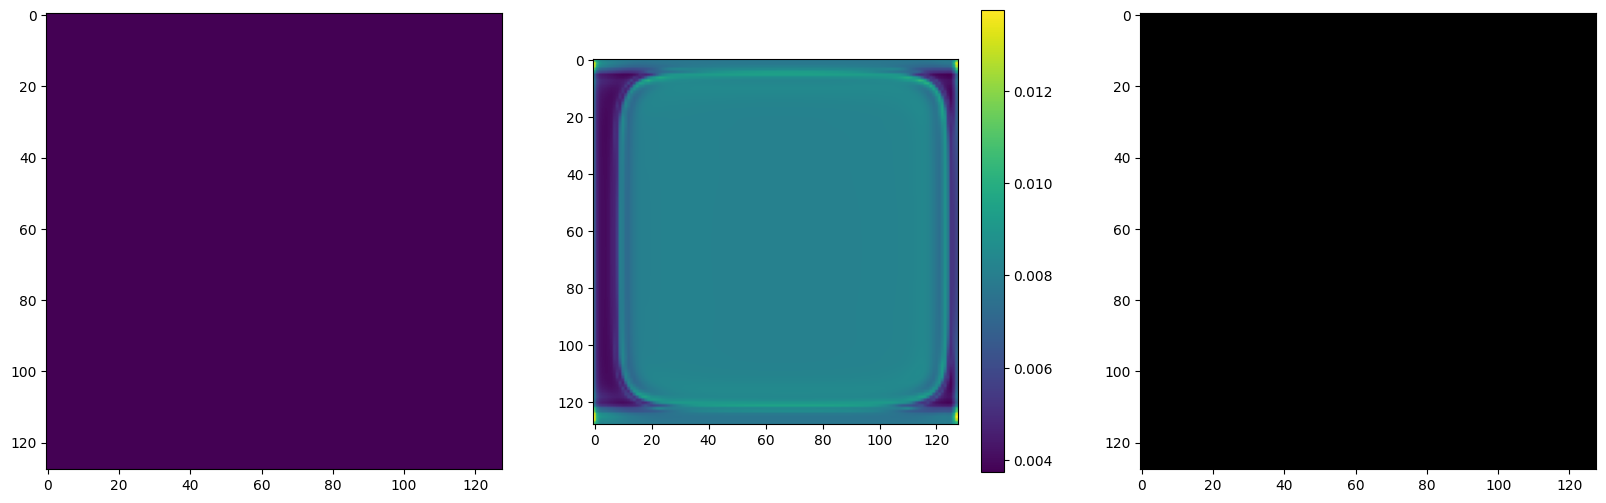

In [ ]:
ix = 22
import torch.nn.functional as nff

plt.rcParams['figure.figsize'] = (20, 6)
plt.subplot(1, 3, 1)
plt.imshow((noutputs[ix]).permute((1,2,0)).cpu().numpy())

plt.subplot(1, 3, 2) # (rows, columns, panel number)
nmask = nff.softmax(outs[ix], dim=-1).permute((1,2,0)).detach().cpu().numpy()
plt.imshow(nmask)
plt.colorbar()

# Draw img2 in the second subplot
plt.subplot(1, 3, 3)
plt.imshow(kornia.color.hsv_to_rgb(ninputs[ix]).permute((1,2,0)).cpu().numpy())
#print(dataset.error_imgs[ix].permute(1, 2, 0).shape)


In [ ]:
import cv2
g_img = cv2.imread(os.path.join(color_dir, "20.jpg"))

t = transforms.ToTensor()(Image.open(os.path.join(color_dir, "20.jpg")))
g_img = kornia.color.rgb_to_hsv(t).permute((1,2,0))

In [ ]:
 # Prepare the output tensor
output = torch.zeros((512, 512))
size = 128

    # Loop over the image patch by patch
for i in range(0, 512, size):
    for j in range(0, 512, size):
            # Extract the patch
        patch = g_img[i:i+size, j:j+size]

            # Make sure it's the right shape
        assert patch.shape == (size, size, 3)

            # Add an extra batch dimension, and send patch to the same device as model
        patch = patch.unsqueeze(0).to(next(model.parameters()).device)

            # Run the model on the patch
        patch_output = model(patch.permute(0,3,1,2))

            # Remove the batch dimension and copy to CPU
        patch_output = patch_output.squeeze(0).cpu()

            # Make sure it's the right shape
        patch_output = patch_output.squeeze(0)
        assert patch_output.shape == (size, size)

            # Insert the output patch into the output image
        output[i:i+128, j:j+128] = patch_output

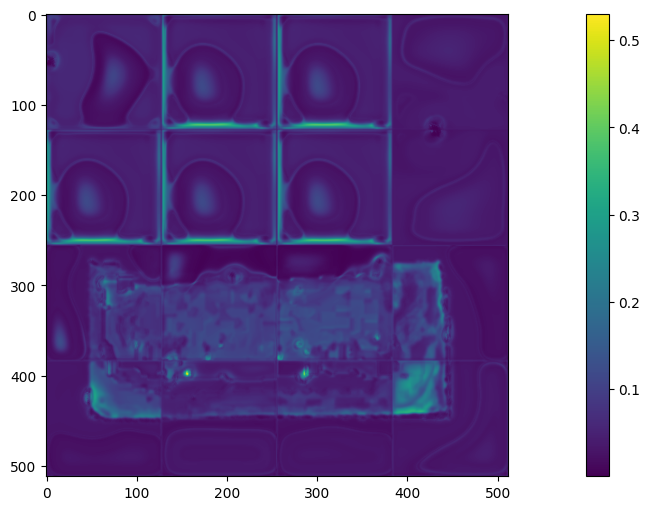

In [ ]:
plt.imshow(nff.sigmoid(output.detach()).cpu().numpy())
plt.colorbar()

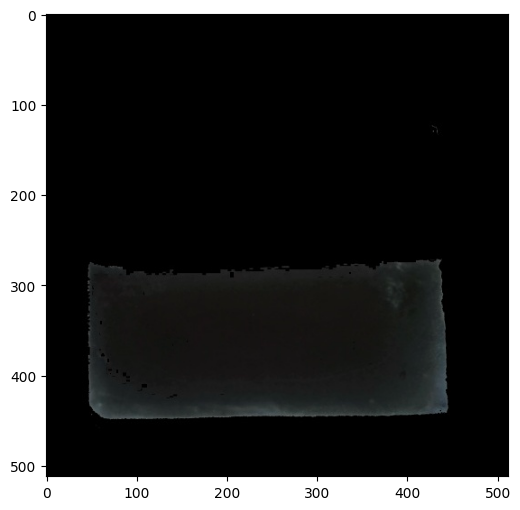

In [ ]:
plt.imshow(cv2.imread(os.path.join(color_dir, "20.jpg")))

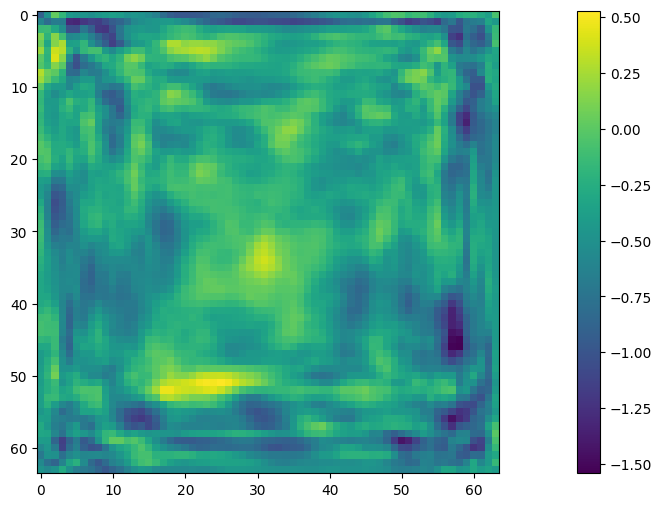

In [ ]:
input = torch.zeros((1, 3, 64, 64))
o = model(input).squeeze(0).permute((1,2,0))
plt.imshow(o.detach())
plt.colorbar()

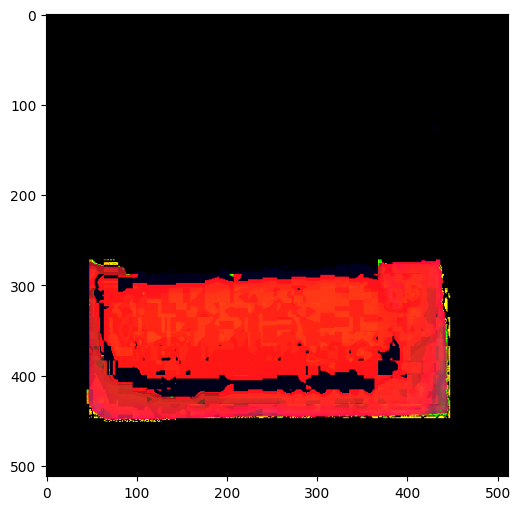

In [ ]:
t = transforms.ToTensor()(Image.open(os.path.join(color_dir, "20.jpg")))
t = kornia.color.rgb_to_hsv(t)
plt.imshow(t.permute((1,2,0)))